In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize,fftpack,interpolate

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



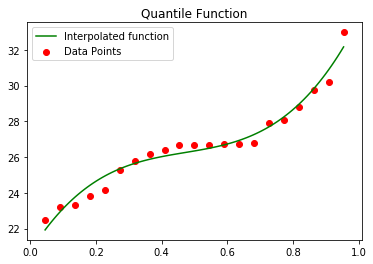

Max speed over 50 years: 32.97989844019469


In [2]:
#load the dataset
import numpy as np
max_speeds = np.load('Data/max-speeds.npy')
years_nb = max_speeds.shape[0]

#array of years
years=np.arange(1,years_nb+1)

#compute the cumulative probability
cprob=years/(years_nb+1) 

#sort the speeds
speeds=np.sort(max_speeds)

#quantile function
quantile_func = interpolate.UnivariateSpline(cprob, speeds)

probs=np.linspace(cprob.min(),cprob.max(),100)
quantile=quantile_func(probs)


#plot to check results
plt.figure(1)
plt.scatter(cprob,speeds,color="red",label="Data Points")
plt.plot(probs,quantile,color="green",label="Interpolated function")
plt.title("Quantile Function")
plt.legend()
plt.show()


#probability as upper 2% quantile
fifty_prob = 1. - 0.02

#guess max speed over 50 years
fifty_wind = quantile_func(fifty_prob)

print("Max speed over 50 years:",fifty_wind)

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Parameters for maxima curve:
Amplitude= 23.0921
 Mean= 6.7358
 Std=-2.2944
 Offset= 15.7794
Parameters for minima curve:
Amplitude= 52.6493
 Mean= 7.1645
 Std=-1.9759
 Offset= -61.3209


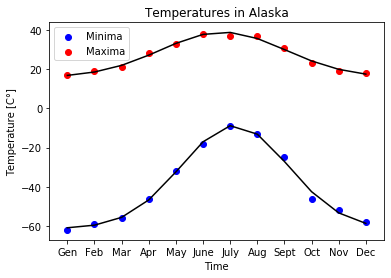

In [3]:
#define arrays of extremes temperatures
maxima=np.array([17,19,21,28,33,38,37,37,31,23,19,18])
minima=np.array([-62,-59,-56,-46,-32,-18,-9,-13,-25,-46,-52,-58])


#months arrays
t=np.arange(1,13,1)
months=["","Gen","Feb","Mar","Apr","May","June","July","Aug","Sept","Oct","Nov","Dec"]

#plot data points
plt.figure(1)
plt.scatter(t,minima,color='blue',marker='o',label="Minima")
plt.scatter(t,maxima,color='red',marker='o',label="Maxima")
plt.xlabel("Time")
plt.ylabel("Temperature [C°]")
plt.xticks(np.arange(0,13,1),labels=months)
plt.legend(loc='upper left')
plt.title("Temperatures in Alaska")


#function that can describe min and max temperatures
def Gauss(x,A,mu,sigma,trans):
    result=A*np.exp(-((x-mu)**2)/(2*sigma**2)) + trans
    return result

#fit the function to the data

#maxima curve
params_max,params_covariance_max=optimize.curve_fit(Gauss,t,maxima)
print("Parameters for maxima curve:")
print("Amplitude= %.4f\n" %params_max[0],"Mean= %.4f\n" %params_max[1],"Std=%.4f\n" %params_max[2],"Offset= %.4f" %params_max[3])
plt.plot(t,Gauss(t,params_max[0],params_max[1],params_max[2],params_max[3]),label='Fitted function',color='black')

#minima curve
params_min, params_covariance_min = optimize.curve_fit(Gauss, t, minima)
print("Parameters for minima curve:")
print("Amplitude= %.4f\n" %params_min[0],"Mean= %.4f\n" %params_min[1],"Std=%.4f\n" %params_min[2],"Offset= %.4f" %params_min[3])
plt.plot(t, Gauss(t, params_min[0], params_min[1], params_min[2],params_min[3]),label='Fitted function',color='black')


plt.show()

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


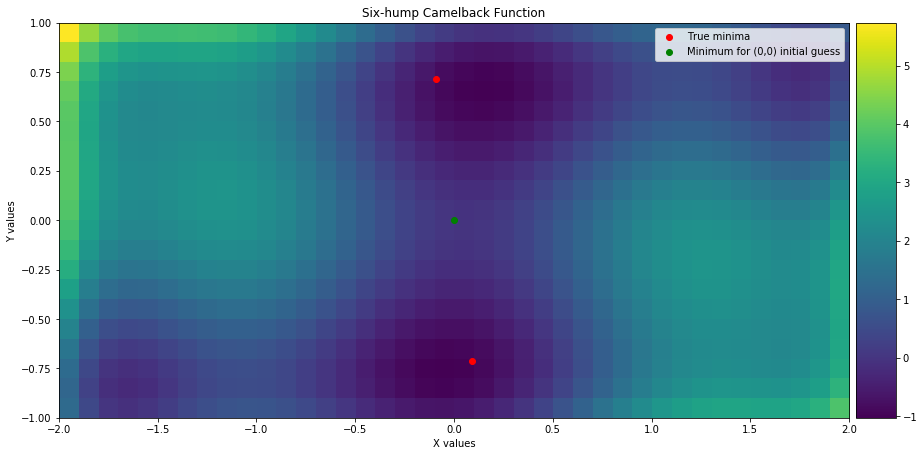

Minimum for initial guess x0=(0.2,0.7):
Function: -1.031628453489877
Coordinates: [-0.08984201  0.7126564 ] 

Minimum for initial guess x0=(-0.2,-0.7):
Function: -1.031628453489877
Coordinates: [ 0.08984201 -0.71265641] 

Minimum for initial guess x0=(0,0):
Function: 0.0
Coordinates: [0. 0.]


In [47]:
#define the function on which I need to calculate the minima
def func(c):
    x=c[0]
    y=c[1]
    first=(4-2.1*x**2+(x**4)/3)*x**2
    second=x*y
    third=(4*y**2 - 4)*y**2
    return first+second+third

#try to find visually the regions
x=np.arange(-2,2,0.1)
#print("X shape:",x.shape)

y=np.arange(-1,1,0.1)
#print("Y shape:",y.shape)

xv,yv=np.meshgrid(x,y)


#plot the interested regions to visualize the minima

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax=plt.subplots(figsize=(15,10))
ax.set_title("Six-hump Camelback Function")
ax.set_xlabel("X values")
ax.set_ylabel("Y values")
image=ax.imshow(func([xv,yv]),extent=[-2,2,-1,1])

#set the size of the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(image,cax=cax)


#look for minimum in upper central region
upper_min=optimize.minimize(func,x0=[0.2,0.7],bounds=[(-1,1),(0,1)])

#look for minimum in lower central region
lower_min=optimize.minimize(func,x0=[-0.2,-0.7],bounds=[(-0.5,0.5),(-1,0)])

#try with (0,0) initial guess
minimum=optimize.minimize(func,x0=[0,0])

#plot the derived minima points
ax.scatter([upper_min.x[0],lower_min.x[0]],[upper_min.x[1],lower_min.x[1]],label="True minima",color='red')
ax.scatter(minimum.x[0],minimum.x[1],color='green',label="Minimum for (0,0) initial guess")
ax.legend()
plt.show()

#print data
print("Minimum for initial guess x0=(0.2,0.7):")
print("Function:",upper_min.fun)
print("Coordinates:",upper_min.x,"\n")

print("Minimum for initial guess x0=(-0.2,-0.7):")
print("Function:",lower_min.fun)
print("Coordinates:",lower_min.x,"\n")

print("Minimum for initial guess x0=(0,0):")
print("Function:",minimum.fun)
print("Coordinates:",minimum.x)

##COMMENTS:

For the six-hump camelback function I found two minima in the region $x=[-2,2],y=[-1,1]$.
The minima are in the coordinates $(x,y)=0.08984201,0.7126564)$ and $(x,y)=(0.08984201,-0.71265641)$; the function at these points takes the value $f(x)=-1.031628453489877$.

For an initial guess of $(x,y)=(0,0)$, the scipy.minimize method gets confused by the presence of the two minima and doesn't work properly. It returns the initial guess point, from which he didn't move, since could not choose the direction of the nearest minimum.

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

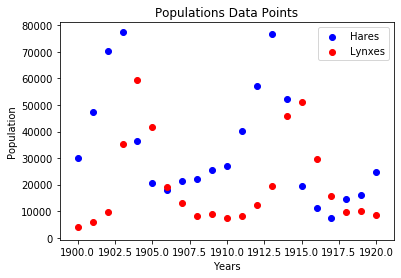

Text(0.5, 0, 'Frequency')

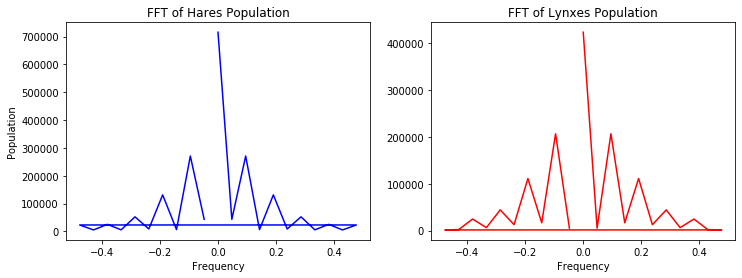

In [4]:
#load the populatin file
data=np.loadtxt("Data/populations.txt").T

#set variables arrays
years=data[0]
hares=data[1]
lynxes=data[2]

#plot data points
plt.figure(1)
plt.scatter(years,hares,color='blue',marker='o',label="Hares")
plt.scatter(years,lynxes,color='red',marker='o',label="Lynxes")
plt.xlabel("Years")
plt.ylabel("Population")
plt.title("Populations Data Points")
plt.legend()
plt.show()

#periodicity analysis
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(12,4))

#hares
hares_fft = fftpack.fft(hares)# The FFT of the signal
power_har = np.abs(hares_fft)# Real power of the signal
sample_freq_har = fftpack.fftfreq(hares.size)# corresponding frequencies

ax1.plot(sample_freq_har, power_har,color="blue")
ax1.set_title("FFT of Hares Population")
ax1.set_ylabel("Population")
ax1.set_xlabel("Frequency")

#lynxes
lynxes_fft=fftpack.fft(lynxes) #FFT of signal
power_lynx=np.abs(lynxes_fft) #Real power of the signal
sample_freq_lynx=fftpack.fftfreq(lynxes.size) #corresponding frequencies

ax2.plot(sample_freq_lynx,power_lynx,color="red")
ax2.set_title("FFT of Lynxes Population")
ax2.set_xlabel("Frequency")


5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Text(0.5, 1.0, 'Filtered Image')

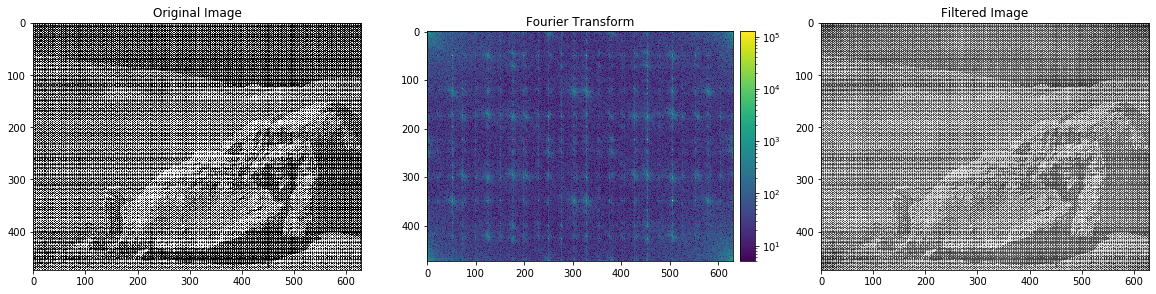

In [6]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

#load the image
image=plt.imread("Data/moonlanding.png")

#plot original image
fig,(ax1,ax2,ax3)=plt.subplots(nrows=1,ncols=3,figsize=(20,10))
ax1.set_title("Original Image")
ax1.imshow(image,cmap="gray")


#2D-FFT
spectrum=fftpack.fft2(image)

#plot fourier transform
transform=ax2.imshow(np.abs(spectrum),norm=LogNorm(vmin=5))
ax2.set_title("Fourier Transform")

#set size of colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(transform,cax=cax)

#clean from noise
spectrum[spectrum>1e3]=0 #bound frequency derived visually from colorbar

#plot filtered image
clean_image=fftpack.ifft2(spectrum).real
ax3.imshow(clean_image, cmap="gray")
ax3.set_title("Filtered Image")